In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import itertools
import helper_functions as hlf

from scipy.stats import randint
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
# open the pre-processed csv file and split the target variable from the classifiers
df = pd.read_csv('dota2_scaled.csv')
df.head()

,Riki,Razor,Morphling,Brewmaster,Slardar,Wisp,Omniknight,Slark,Ogre Magi,Chaos Knight,...,Support,Offlane,Mid,Roamer,Nuke/Disable,High_Win,Low_Win,Most_Picked_719,Most_Picked_720,Won
0,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.493732,1.007526,1.261730,0.157217,3.185349,0.474901,-0.814275,-0.678438,-0.650247,1
1,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.493732,1.007526,0.266544,0.157217,-0.254635,0.474901,0.667752,-0.678438,1.141562,1
2,-0.190351,6.441500,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-1.621490,-1.304373,0.266544,-1.058379,0.892026,1.805530,-0.814275,-0.678438,-0.650247,1
3,-0.190351,6.441500,5.349299,-0.181034,-0.187513,-0.21094,5.444586,-0.245093,-0.197112,-0.211026,...,0.634025,-1.304373,-0.728642,0.157217,0.892026,-0.855727,0.667752,-0.678438,-0.650247,1
4,5.253443,-0.155243,-0.186940,5.523822,-0.187513,-0.21094,-0.183669,-0.245093,5.073260,-0.211026,...,-0.493732,-0.148424,-0.728642,0.157217,0.892026,-0.855727,-0.814275,-0.678438,1.141562,1


In [3]:
#separate the target variable
labels = df['Won']
df.drop(['Won'], axis=1, inplace=True)

In [4]:
# Create seprate training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.25)

#   KNN Model:

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# run initial model with default values
knn = KNeighborsClassifier()
knn.fit(x_train, y_train.values.ravel())

knn_pred = knn.predict(x_test)

_, _ = hlf.print_metrics(y_test, knn_pred, print_score=True)

Recall Score: 53.33
Accuracy Score: 51.89


0.7660119497974249

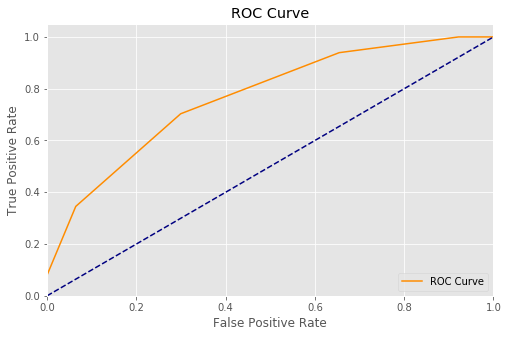

In [8]:
hlf.plot_roc_curve(knn, x_train, y_train)

## Initial KNN model performed poorly
Recall Score: 53.11%

Accuracy Score: 52.89%

In [ ]:
def multiple_knn(df, labels, ks=[5]):
    x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2)
    best_acc = 0
    best_k = 0
    scores = []

    for k in tqdm(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train.values.ravel())
        test_predict = knn.predict(x_test)
        score = hlf.print_metrics(y_test, test_predict)
        scores.append(score)
        
        if best_acc < score[1]:
            best_acc = score[1]
            best_k = k
            
        
    return best_acc, best_k, scores

In [ ]:
# run model again k = 2, 4, 5, 6, 7
acc, k, scores = multiple_knn(df, labels, ks=[2, 4, 5, 6, 7])
print(f"scores: {scores}, k: {k}")

In [ ]:
# run model again k =  5, 6, 7, 8, 9
acc, k, scores = multiple_knn(df, labels, ks=[5, 6, 7, 8, 9])
print(f"scores: {scores}, k: {k}")

### KNN = 9


#### Recall - 54.93% 

#### Accuracy = 53,58%


In [ ]:
# run KNN again with k neighbots 
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train.values.ravel())

# predict
k9_predict = knn.predict(x_test)

# test how the model performed
k9_recall, k9_acc = print_metrics(y_test, k9_predict, print_score=True)

# plot confusion matrix
plot_confusion_matrix(y_test, k9_predict)

In [ ]:
plot_roc_curve(knn, x_test, y_test)

# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [ ]:
tree = DecisionTreeClassifier(random_state=10)  
tree.fit(x_train, y_train)

# predict
tree_pred = tree.predict(x_test)

# get prediction accuracy
tree_recall, tree_acc = hlf.print_metrics(y_test, tree_pred, print_score=True)

In [ ]:
# Identify the optimal tree depth for given data
def find_optimal_depth(x_train, x_test, y_train, y_test):   
    #declare variables
    max_depths = np.linspace(1, 15, 15, endpoint=True)
    train_results = []
    test_results = []
    # iterate over the different depths
    for depth in max_depths:
        trees = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        trees.fit(x_train, y_train)
        
        # Add auc score to train list
        train_pred = trees.predict(x_train)
        fpr, tpr, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(fpr, tpr)
        train_results.append(roc_auc)
        
        # Add auc score to test list
        test_pred = trees.predict(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, test_pred)
        roc_auc = auc(fpr, tpr)
        test_results.append(roc_auc)
        
    plt.figure(figsize=(12,6))
    plt.plot(max_depths, train_results, 'b', label='Train AUC')
    plt.plot(max_depths, test_results, 'r', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.legend()
    plt.show()
    pass

In [ ]:
# find the optimal depth to narrow down search and avoid over fitting
hlf.find_optimal_depth(x_train, x_test, y_train, y_test)

In [ ]:
# using random search to find the optimal hyper paramters
tree_dist = {"max_depth": randint(4, 8),
             "max_features": randint(1, 16),
             "min_samples_leaf": randint(2, 1000),
             "min_samples_split": randint(2, 1000),
            }

tree_clf = RandomizedSearchCV(DecisionTreeClassifier(), tree_dist, n_iter=1000)
tree_clf.fit(x_train, y_train.values.ravel())

In [ ]:
# fit the optimal tree
optimal_tree = tree_clf.best_estimator_
optimal_tree.fit(x_train, y_train)
# predict
opt_tree_pred = optimal_tree.predict(x_test)

# get prediction accuracy
opt_tree_recall, opt_tree_acc = print_metrics(y_test, opt_tree_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, opt_tree_pred)

In [ ]:
hlf.plot_feature_importance(optimal_tree, x_test, n=15)

In [ ]:
print(tree_grid.best_params_)

### Optimal Parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3}

#### Recall - 43.99% 

#### Accuracy = 55.45%

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
# get a baseline how random forest performs
forest = RandomForestClassifier(random_state=123)
forest.fit(x_train, y_train.values.ravel())

# predcit
forest_test_pred = forest.predict(x_test)

# check prediction metrics
f_recall, f_acc = hlf.print_metrics(y_test, forest_test_pred, print_score=True)

### Random Forest using randonsearch

In [ ]:
# using random search to find the optimal hyper paramters
forest_dist = {"max_depth": randint(1, 8),
               "max_features": randint(1, 16),
               "min_samples_leaf": randint(2, 1000),
               "min_samples_split": randint(2, 1000),
              }

forest_clf = RandomizedSearchCV(RandomForestClassifier(), forest_dist, n_iter=1000)
forest_clf.fit(x_train, y_train.values.ravel())

In [ ]:
# fit the optimal random forest
optimal_forest = forest_clf.best_estimator_
optimal_forest.fit(x_train, y_train)

# predict
opt_forest_pred = optimal_forest.predict(x_test)

# get prediction metrics
opt_forest_recall, opt_forest_acc = hlf.print_metrics(y_test, opt_forest_pred, print_score=True)

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_forest_pred)
print(forest_clf.best_params_)

In [ ]:
hlf.plot_feature_importance(optimal_forest, x_test)

### Optimal Parameters: {'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 81, 'min_samples_split': 573}

#### Recall Score: 57.42%

#### Accuracy Score: 54.88%

# AdaBoost

In [ ]:
# get a baseline on how ada boost performs
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train.values.ravel())

# predict
adaboost_test_pred = adaboost.predict(x_test)

# test how the model performs 
ada_recall, ada_accuracy = print_metrics(y_test, adaboost_test_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, adaboost_test_pred)

### AdaBoost Using Gridsearch

In [ ]:
adaboost_param_grid = {'n_estimators': [70, 150, 200, 250, 270, 300],
                       'learning_rate': [0.4, 0.2, 0.1]
                      }

#fit adaboost with a paramters grid
ada_grid_search = GridSearchCV(adaboost, adaboost_param_grid, scoring='accuracy', cv=4)
ada_grid_search.fit(x_train, y_train.values.ravel())

In [ ]:
opt_ada = ada_grid_search.best_estimator_

# predict 
adagrid_pred = opt_ada.predict(x_test)

# test how badly the model performs 
adagrid_recall, adagrid_accuracy = print_metrics(y_test, adagrid_pred, print_score=True)

# best paramters
best_ada_params = ada_grid_search.best_params_
print(best_ada_params)

In [ ]:
# changing the hyper paramaters grid and running again
adaboost_param_grid2 = {'n_estimators': [50, 125, 150, 175, 200],
                        'learning_rate': [0.2, 0.4, 0.5]
                       }

# fitting a new model with different hyper paramaters
ada_grid_search2 = GridSearchCV(adaboost, adaboost_param_grid2, scoring='accuracy', cv=4)
ada_grid_search2.fit(x_train, y_train.values.ravel())

# predict 
adagrid_pred2 = ada_grid_search2.predict(x_test)

# test how well the model performs 
adagrid_recall2, adagrid_accuracy2 = print_metrics(y_test, adagrid_pred2, print_score=True)

In [ ]:
# fit the optimal paramaters for adaboost
optimal_ada = ada_grid_search2.best_estimator_
optimal_ada.fit(x_train, y_train)

# predict
opt_ada_pred = optimal_ada.predict(x_test)

# get prediction accuracy
opt_ada_recall, opt_ada_acc = print_metrics(y_test, opt_ada_pred, print_score=True)

# best paramters
best_ada_params2 = ada_grid_search2.best_params_
print(best_ada_params2)

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_ada_pred)

In [ ]:
hlf.plot_feature_importance(optimal_ada, x_test)

### Optimal Parameters: {'learning_rate': 0.5, 'n_estimators': 200}
#### Recall = 57.42%
#### Accuracy = 57.08%

# XGBoost

In [ ]:
import xgboost as xgb

# check baseline accuracy for xgboost
xgbooster = xgb.XGBClassifier()
xgbooster.fit(x_train, y_train.values.ravel())

# predict
xgb_pred = xgbooster.predict(x_test)

# test how badly the model performs 
xgb_recall, xgb_accuracy = print_metrics(y_test, xgb_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, xgb_pred)

In [ ]:
plot_feature_importance(xgbooster, x_train, n=30)

### XGBoost Using Gridsearch

In [ ]:
xg_param_grid = {'learning_rate': [0.3], 'max_depth': [5, 7], 
                 'min_child_weight': [4, 5, 6], 'subsample': [0.6, 0.7],
                 'n_estimators': [90, 120, 150]
                }

In [ ]:
xg_grid = GridSearchCV(xgbooster, xg_param_grid, scoring='accuracy', cv=3, n_jobs=1)
xg_grid.fit(x_train, y_train.values.ravel())

# predict
xg_grid_preds = xg_grid.predict(x_test)

# test how badly the model performs 
xg_grid_recall, xg_grid_acc = hlf.print_metrics(y_test, xg_grid_preds, print_score=True)
best_parameters = xg_grid.best_params_

print(best_parameters)

In [ ]:
# running the model again with slightly similar hyperparamaters
xg_param_grid2 = {'learning_rate': [0.3], 'max_depth': [4, 5], 
                 'min_child_weight': [6, 7], 'subsample': [0.7, 0.8],
                 'n_estimators': [100, 120, 130]
                }

In [ ]:
xg_grid2 = GridSearchCV(xgbooster, xg_param_grid2, scoring='accuracy', cv=3, n_jobs=1)
xg_grid2.fit(x_train, y_train.values.ravel())

# predict
xg_grid_preds2 = xg_grid2.predict(x_test)

# test how badly the model performs 
xg_grid2_recall, xg_grid2_acc = hlf.print_metrics(y_test, xg_grid_preds2, print_score=True)
best_parameters2 = xg_grid2.best_params_

print(best_parameters2)

In [ ]:
# run xgboost again with the new paramaters
opt_xgb = xg_grid2.best_estimator_
opt_xgb.fit(x_train, y_train.values.ravel())

# predict
opt_xgb_pred = opt_xgb.predict(x_test)

# test how badly the model performs 
opt_xgb_recall, opt_xgb_accuracy = hlf.print_metrics(y_test, opt_xgb_pred, print_score=True)

In [ ]:
hlf.plot_confusion_matrix(y_test, xgb_pred2)

In [ ]:
hlf.plot_feature_importance(opt_xgb, x_test)

In [ ]:
plot_feature_importance(xgbooster2, x_train, n=30)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# check the baseline how logistic regression works
log_reg = LogisticRegression(fit_intercept = False, C = 1e12) #Starter code
log_mod = log_reg.fit(x_train, y_train)

# predict
log_pred = log_reg.predict(x_test)

# test how well the model performs 
log_recall, log_acc = print_metrics(y_test, log_pred, print_score=True)

### Logistic regression using Gridsearch

In [ ]:
log_grid = {"C": np.logspace(0, 10, 15)}

log_reg_grid = GridSearchCV(log_mod, log_grid, scoring="accuracy", cv=4)
log_reg_grid = log_reg_grid.fit(x_train, y_train.values.ravel())

# predict
grid_log_pred = log_reg.predict(x_test)

# test how badly the model performs 
grid_log_recall, grid_log_acc = print_metrics(y_test, grid_log_pred, print_score=True)
print(log_reg_grid.best_score_)
print(log_reg_grid.best_params_)

In [ ]:
opt_logis = log_reg_grid.best_estimator_
opt_logis.fit(x_train, y_train)

opt_logis_pred = opt_logis.predict(x_test)
# test how well the model performs 
opt_log_recall, opt_log_acc = print_metrics(y_test, opt_logis_pred, print_score=True)

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_logis_pred)

In [ ]:
plot_roc_curve(adaboost, x_test, y_test)

### Optimal

# SVM


In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# Reduce dimonsionality so my computer won't explode trying to run SVM with 30k observations and 114 dimensions
x_reduced = PCA(n_components=30).fit_transform(df)

In [ ]:
rx_train, rx_test, ry_train, ry_test = train_test_split(x_reduced, labels,
                                                        test_size=0.25,
                                                        random_state=123)


In [ ]:
# to get a base line run model with default paramters and different kernels
SVMp = SVC(kernel='poly', max_iter=3500)
SVMp.fit(rx_train, ry_train)
print(SVMp.score(rx_test, ry_test))

In [ ]:
# to get a base line run model with default paramters and different kernels
SVMs = SVC(kernel='rbf', max_iter=3500)
SVMs.fit(rx_train, ry_train)
print(SVMs.score(rx_test, ry_test))

In [ ]:
# to get a base line run model with default paramters
SVM = LinearSVC(max_iter=3500)
SVM.fit(rx_train, ry_train)
print(SVM.score(rx_test, ry_test))

### LinearSVC using Gridsearch

In [ ]:
c = np.logspace(start=-20, stop=400, base=1.05)
svm_grid = {'C': c}

svm_grid = GridSearchCV(SVM, param_grid=svm_grid, cv=4, n_jobs=-1, scoring='accuracy')
svm_grid.fit(rx_train, ry_train)

In [ ]:
opt_svm = svm_grid.best_estimator_
opt_svm.fit(rx_train, ry_train)

# predict
opt_svm_pred = opt_svm.predict(rx_test)

# check how badly the model predicts
opt_svm_recall, opt_svm_acc = print_metrics(ry_test, opt_svm_pred, print_score=True)
opt_svm.score(rx_test, ry_test)

In [ ]:
# changing the penalty from 'l2' to 'l1' and check how badly the model predicts
SVMl1 = LinearSVC(penalty='l1', max_iter=3500, dual=False)

svml1_grid = GridSearchCV(SVMl1, param_grid=svm_grid, cv=4, n_jobs=-1, scoring='accuracy')
svml1_grid.fit(rx_train, ry_train)

In [ ]:
optl1_svm = svml1_grid.best_estimator_
optl1_svm.fit(rx_train, ry_train)

# predict
opt_svml1_pred = optl1_svm.predict(rx_test)

# test how well the model performs 
opt_svml1_recall, opt_svml1_acc = print_metrics(ry_test, opt_svml1_pred, print_score=True)
optl1_svm.score(rx_test, ry_test)